In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
%matplotlib inline

## 3.1.4 Model Comparison - OLS and KNN Regression
You now know two kinds of regression and two kinds of classifier. So let's use that to compare models!

Comparing models is something data scientists do all the time. There's very rarely just one model that would be possible to run for a given situation, so learning to choose the best one is very important.

Here let's work on regression. Find a data set and build a KNN Regression and an OLS regression. Compare the two. How similar are they? Do they miss in different ways?

Create a Jupyter notebook with your models. At the end in a markdown cell write a few paragraphs to describe the models' behaviors and why you favor one model or the other. Try to determine whether there is a situation where you would change your mind, or whether one is unambiguously better than the other. Lastly, try to note what it is about the data that causes the better model to outperform the weaker model. Submit a link to your notebook below.

### 1. Data Exploration and Feature Selection
For this challenge, I'll be using a wine quality data set obtained from
https://archive.ics.uci.edu/ml/datasets/Wine+Quality

The objective is to predict **quality** based on select chemical parameters.

In [148]:
# Load and inspect data
df = pd.read_csv('winequality-red.csv', delimiter=';')
df.head()
df.columns = ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sug', 'chlorides', 'free_sulf_diox', 
              'total_sulf_diox', 'density', 'pH', 'sulphates', 'alcohol', 'quality']

In [149]:
df.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sug,chlorides,free_sulf_diox,total_sulf_diox,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [150]:
# Inspect variable correlation for feature selection
corr_matrix = df.corr()
print(corr_matrix)

                  fixed_acidity  volatile_acidity  citric_acid  residual_sug  \
fixed_acidity          1.000000         -0.256131     0.671703      0.114777   
volatile_acidity      -0.256131          1.000000    -0.552496      0.001918   
citric_acid            0.671703         -0.552496     1.000000      0.143577   
residual_sug           0.114777          0.001918     0.143577      1.000000   
chlorides              0.093705          0.061298     0.203823      0.055610   
free_sulf_diox        -0.153794         -0.010504    -0.060978      0.187049   
total_sulf_diox       -0.113181          0.076470     0.035533      0.203028   
density                0.668047          0.022026     0.364947      0.355283   
pH                    -0.682978          0.234937    -0.541904     -0.085652   
sulphates              0.183006         -0.260987     0.312770      0.005527   
alcohol               -0.061668         -0.202288     0.109903      0.042075   
quality                0.124052         

Based on the correlation matrix, I will select only features with a positive correlation >0.10 to the target variable 'quality'.  Choosing features with positive and negative correlations to the predicted value would lead to noise in the prediction model.

In [334]:
# Define feature df
data = df.loc[:, ['fixed_acidity', 'citric_acid', 'sulphates', 'alcohol', 'quality']]

# Trimmed correlation matrix
corr_matrix_data = data.corr()
print(corr_matrix_data)

               fixed_acidity  citric_acid  sulphates   alcohol   quality
fixed_acidity       1.000000     0.671703   0.183006 -0.061668  0.124052
citric_acid         0.671703     1.000000   0.312770  0.109903  0.226373
sulphates           0.183006     0.312770   1.000000  0.093595  0.251397
alcohol            -0.061668     0.109903   0.093595  1.000000  0.476166
quality             0.124052     0.226373   0.251397  0.476166  1.000000


Citric acid and fixed acidity are highly correlated.  To simplify model inputs, I'll remove fixed acidity because it has a weaker correlation to quality and therefore less predictive power.  

In [335]:
# Modify feature df 
data = df.loc[:, ['citric_acid', 'sulphates', 'alcohol', 'quality']]

# Trimmed correlation matrix
corr_matrix_data = data.corr()
print(corr_matrix_data)

             citric_acid  sulphates   alcohol   quality
citric_acid     1.000000   0.312770  0.109903  0.226373
sulphates       0.312770   1.000000  0.093595  0.251397
alcohol         0.109903   0.093595  1.000000  0.476166
quality         0.226373   0.251397  0.476166  1.000000


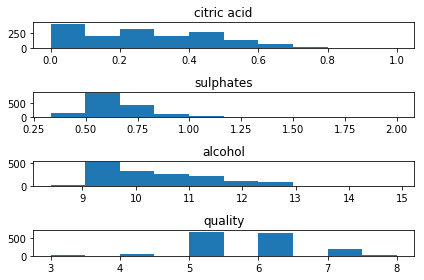

In [336]:
# Inspect distribution of features
# How do I make the grid layout taller? 
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=False, sharey=False)

plt.plot(figsize=(20,20)) # doesn't appear to do anything

ax1.hist(data['citric_acid'])
ax1.set_title('citric acid')

ax2.hist(data['sulphates'])
ax2.set_title('sulphates')

ax3.hist(data['alcohol'])
ax3.set_title('alcohol')

ax4.hist(data['quality'])
ax4.set_title('quality')

f.tight_layout()

plt.show()

### 2. Create train/test data sets for hold out validation

In [337]:
# Split data into train/test sets (70/30)
x = data.loc[:, ['citric_acid', 'sulphates', 'alcohol']]
y = data.loc[:, ['quality']]

# Split data using sklearn
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=43)

### 3. OLS Regression Model

In [338]:
# Import linear model
from sklearn import linear_model

# Instantiate and fit model with test data
lm = linear_model.LinearRegression()
lm.fit(x_train, y_train)

# Get score for training data
print('Regression score - training data:', lm.score(x_train, y_train))

# Get score for test data
print('Regression score - test data:', lm.score(x_test, y_test))

Regression score - training data: 0.25415375300663634
Regression score - test data: 0.33514429069401663


The model does not appear to be overfit; however, the model is not performing particularly well on either data set.

In [340]:
# Examine model parameters in greater depth using StatsModels

# Import model
import statsmodels.formula.api as smf

# Join x_train & y_train into one variable
data = x_train.join(y_train)

#specify interactions 
linear_formula = 'quality ~ citric_acid+sulphates+alcohol'

# run validation
lm = smf.ols(formula=linear_formula, data=data).fit()

# get results
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     126.6
Date:                Sat, 10 Mar 2018   Prob (F-statistic):           1.35e-70
Time:                        16:38:38   Log-Likelihood:                -1165.2
No. Observations:                1119   AIC:                             2338.
Df Residuals:                    1115   BIC:                             2359.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.6651      0.213      7.819      

#### OLS Summary
Low R^2 values, indicating lots of unexplained variance in Y given X, although F-statistic reveals significant test and all parameters are significant (is F-test really all that valuable?). Poor model performance likely due to non-parametric distribution of predictors, poor feature selection.

### 4. KNN Regression Model

In [307]:
# Import library
from sklearn import neighbors

In [308]:
# ************************ K = 1 **********************************

# Build model, fit with training data, set K=1, no weighting
knn_1 = neighbors.KNeighborsRegressor(n_neighbors=1)
knn_1.fit(x_train, y_train)

print('Train:', knn_1.score(x_train, y_train))
print('Test:', knn_1.score(x_test, y_test))
 

Train: 0.9758861274563243
Test: 0.05686269617505413


KNN_1 is overfit.  Performance on test data is much worse than training data.

In [341]:
# ************************** K = 5 ********************************

# Build model, K=5, no weighting
knn_5 = neighbors.KNeighborsRegressor(n_neighbors=5)
knn_5.fit(x_train, y_train)

print('Train:', knn_5.score(x_train, y_train))
print('Test:', knn_5.score(x_test, y_test))

Train: 0.5062046288291533
Test: 0.31926445270590564


KNN_5 is less overfit than KNN_1, however, the model still exhibits overfitting and does not perform that well.  This version of the model performs roughly the same as the OLS model.

In [347]:
# *********************** K = 5, Distance Weighted *************************

# Build model, K=5, weighting
knn_5w = neighbors.KNeighborsRegressor(n_neighbors=5, weights='distance')
knn_5w.fit(x_train, y_train)

print('Train:', knn_5w.score(x_train, y_train))
print('Test:', knn_5w.score(x_test, y_test))

Train: 0.9881794742432961
Test: 0.37550577922385764


The model performs quite well on the training data set, but still shows overfitting.  Despite the overfitting, this is the best version of the model so far.

## Results:
In general, all models perform poorly indicating better feature selection could be done.  The features should also be normalized due to their varying scales.  The OLS model is less prone to overfitting than KNN Regression.  

#### Questions:

If doing data transformation - does it happen before testing any models or do you incorporate/customize it for each individual model (i.e. transform to normal distribution for linear model, but not KNN, and normalize for KNN but not OLS)?  At what point do you untransform it?  Do you need to worry about undoing the transform in order to determine the model score?